Downloading val images

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!wget -P /content/ http://images.cocodataset.org/zips/val2014.zip

!unzip /content/val2014.zip -d /content/

Streaming output truncated to the last 5000 lines.
 extracting: /content/val2014/COCO_val2014_000000535608.jpg  
 extracting: /content/val2014/COCO_val2014_000000279145.jpg  
 extracting: /content/val2014/COCO_val2014_000000243495.jpg  
 extracting: /content/val2014/COCO_val2014_000000225791.jpg  
 extracting: /content/val2014/COCO_val2014_000000428067.jpg  
 extracting: /content/val2014/COCO_val2014_000000059383.jpg  
 extracting: /content/val2014/COCO_val2014_000000558498.jpg  
 extracting: /content/val2014/COCO_val2014_000000376123.jpg  
 extracting: /content/val2014/COCO_val2014_000000191304.jpg  
 extracting: /content/val2014/COCO_val2014_000000171062.jpg  
 extracting: /content/val2014/COCO_val2014_000000014549.jpg  
 extracting: /content/val2014/COCO_val2014_000000121152.jpg  
 extracting: /content/val2014/COCO_val2014_000000276596.jpg  
 extracting: /content/val2014/COCO_val2014_000000029431.jpg  
 extracting: /content/val2014/COCO_val2014_000000036349.jpg  
 extracting: /conte

Downloading annotations

In [ ]:
!wget -P /content/ http://images.cocodataset.org/annotations/annotations_trainval2014.zip

!unzip /content/annotations_trainval2014.zip -d /content/

--2023-05-22 08:22:10--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.177.43, 52.217.90.20, 3.5.28.136, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.177.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘/content/annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  13.3MB/s    in 20s     

2023-05-22 08:22:31 (12.2 MB/s) - ‘/content/annotations_trainval2014.zip’ saved [252872794/252872794]

Archive:  /content/annotations_trainval2014.zip
  inflating: /content/annotations/instances_train2014.json  
  inflating: /content/annotations/instances_val2014.json  
  inflating: /content/annotations/person_keypoints_train2014.json  
  inflating: /content/annotations/person_keypoints_val2014.json  
  inflating: /content/annotations/captions_train2014.json  
  inflating: /co

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
from pycocotools.coco import COCO

# path to cocoapi directory
cocoapi_dir = r"/content"
dir_type = "val2014"
# initialize COCO API for instance annotations
instances_ann_file = os.path.join(
    cocoapi_dir, "annotations", f"instances_{dir_type}.json"
)
coco = COCO(instances_ann_file)

# initialize COCO API for caption annotations
captions_ann_file = os.path.join(cocoapi_dir, "annotations", f"captions_{dir_type}.json")
coco_caps = COCO(captions_ann_file)

# get image ids
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=5.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [ ]:
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from nltk.translate.bleu_score import corpus_bleu
from pycocotools.coco import COCO
import torch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
model.to(device)

In [ ]:
pred_imgs = []
true_caps = []
for i in ids:
  img_id = str(coco.anns[i]["image_id"])
  image_id = coco.anns[i]["image_id"]
  ann_id = coco.loadImgs(image_id)[0]['id']
  ann_ids = coco_caps.getAnnIds(imgIds=ann_id)
  true_caps.append(list(map(lambda ann: ann['caption'], coco_caps.loadAnns(ann_ids))))
  full_id = "0"*(12 - len(img_id)) + img_id
  path = f"/content/val2014/COCO_val2014_{full_id}.jpg"
  image = Image.open(path)
  pred_imgs.append(image)

In [ ]:
generated_caps = []
for i in range(0, len(ids), 332):
  generated_ids = model.generate(**processor(images=pred_imgs[i:i+332], return_tensors="pt").to(device))
  generated_caps += processor.batch_decode(generated_ids, skip_special_tokens=True)
pred_caps = list(map(lambda x: x.strip(), generated_caps))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
def bleu_score_blip(true_sentences, predicted_sentences):
    hypotheses = []
    references = []
    n = len(predicted_sentences)
    for i in range(0, n):
      img_refs = [cap.split() for cap in true_sentences[i]]
      references.append(img_refs)
      hypotheses.append(predicted_sentences[i].strip().split())

    return corpus_bleu(references, hypotheses)

In [2]:
bleu_score_blip(true_caps, pred_caps)

0.3561499728509457


In [ ]:
import matplotlib.pyplot as plt

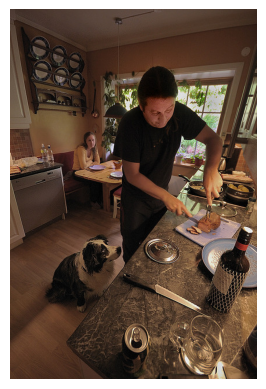

a child sitting in a car with a hot dog and french fries


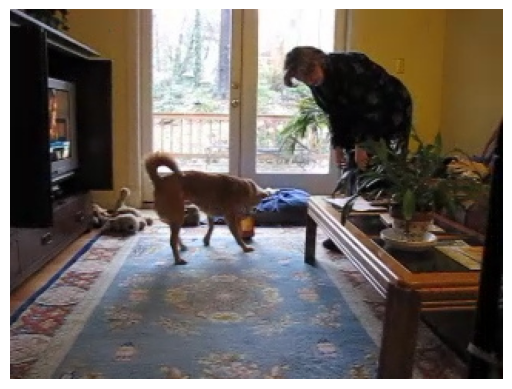

a bicycle with a plate of hot dogs and a coke


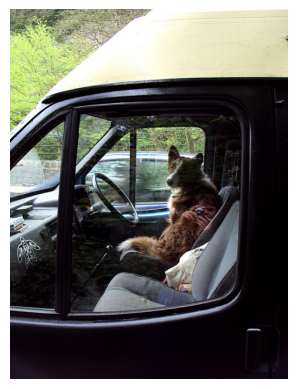

a bicycle with a plate of hot dogs and a coke


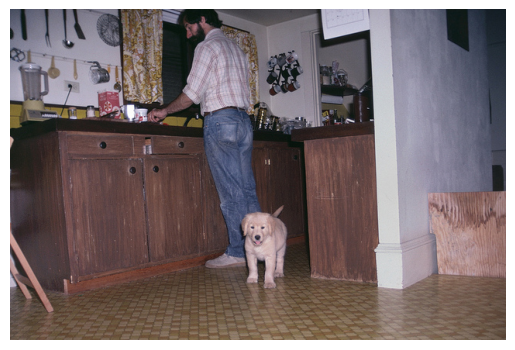

a bicycle with a plate of hot dogs and a coke


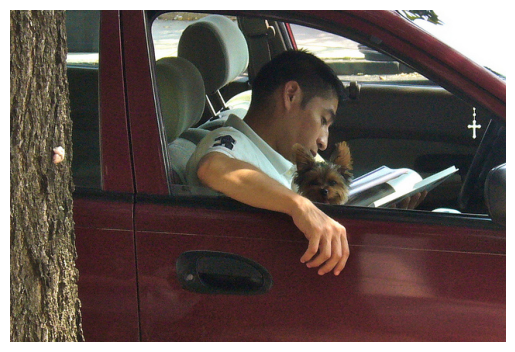

a bicycle with a plate of hot dogs and a coke


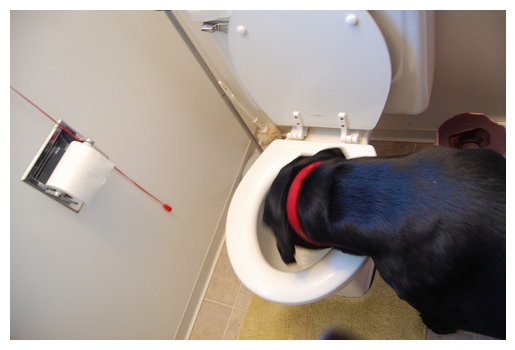

a man on a motorcycle riding down the street


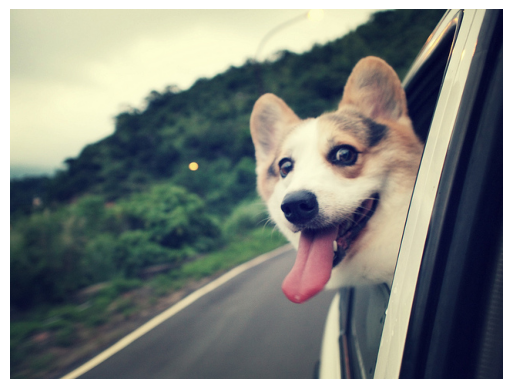

a group of people riding on motorcycles


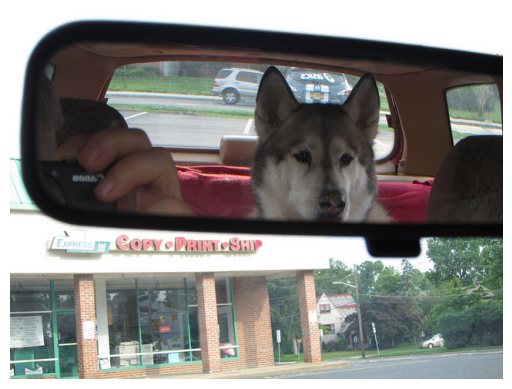

a dog laying on the floor in a bathroom


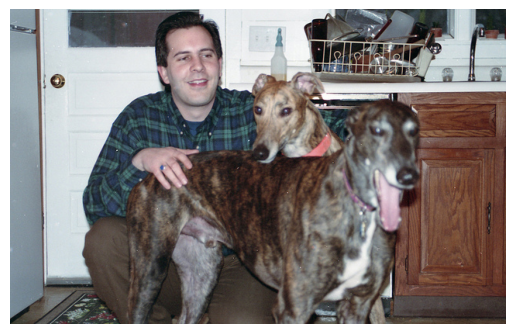

a man riding a bicycle in front of a building


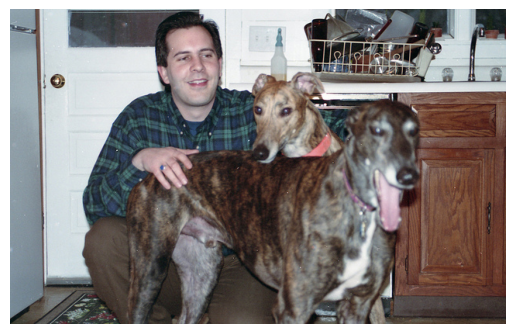

a bathroom with marble flooring and a marble sink


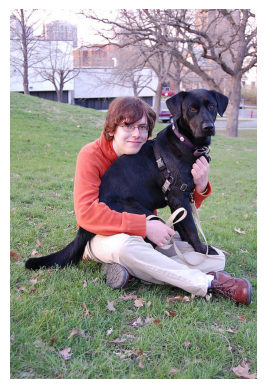

a dog standing on a rug in a bathroom


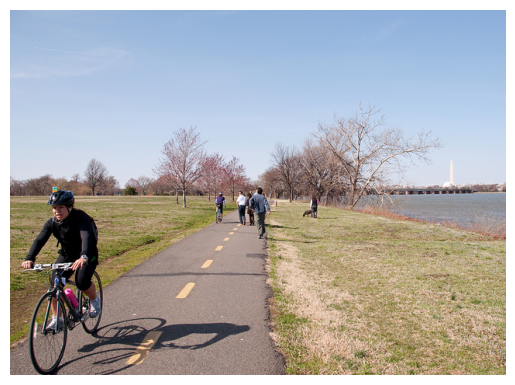

a dog laying on the ground


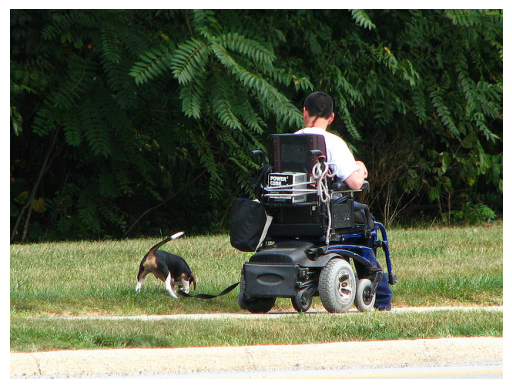

a girl wearing a blue sweater


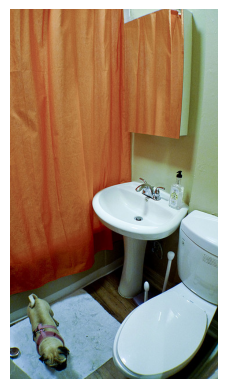

a black dog laying on the floor


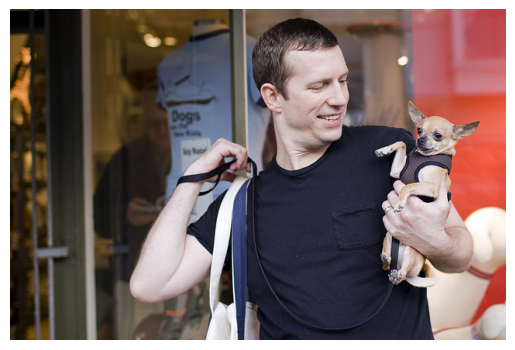

a woman in an orange shirt


In [ ]:
j=0

for i in ids[:10]:
  img_id = str(coco.anns[i]["image_id"])
  full_id = "0"*(12 - len(img_id)) + img_id
  path = f"/content/val2014/COCO_val2014_{full_id}.jpg"
  image = Image.open(path)
  plt.axis("off")
  plt.imshow(image)
  plt.show()
  print(pred_caps[j])
  j+=1